In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import time
np.set_printoptions(precision=4, suppress=True)
mpl.style.use('dark_background')

## Correlation functions

In [2]:
def pixel_corr(A, B):
    # A and B have shape N x m x n, where images are size m x n
    # find mean value of a single pixel over the N images
    shifted_A = A - np.mean(A, axis=0)
    shifted_B = B - np.mean(B, axis=0)
    # formula given above + perturbing denominator by
    # a small eps so that a constant series gets 
    # a correlation of 0 instead of Inf or NaN
    eps = 1e-10
    return (np.sum(shifted_A * shifted_B, axis=0)) \
                / (np.sqrt(np.sum(shifted_A**2, axis=0) \
                            * np.sum(shifted_B**2, axis=0)) + eps)

In [3]:
def uncent_pixel_corr(A, B):
    # A and B have shape N x m x n, where images are size m x n
    # find mean value of a single pixel over the N images
    # formula given above + perturbing denominator by
    # a small eps so that a constant series gets 
    # a correlation of 0 instead of Inf or NaN
    eps = 1e-10
    return (np.sum(A * B, axis=0)) \
                / (np.sqrt(np.sum(A**2, axis=0) \
                            * np.sum(B**2, axis=0)) + eps)

## Jacobian functions

In [4]:
@tf.function
def batch_JJt_diag(x, model):
    # note that x should be a tf.Variable with N vectors
    # of length n
    with tf.GradientTape() as tape:
        y = model(x)
    # if each output vector in y has length d then each
    # batch of Jacobians has shape N x d x n
    jacobians = tape.batch_jacobian(y, x)
    # the diagonal of JJt can be obtained via summing along
    # the third axis (size n) of the elementwise square
    # of the Jacobian. The batch of JJt diagonals will 
    # be size N x d 
    return tf.reduce_sum(jacobians**2, axis=2)

In [5]:
@tf.function
def batchJ(x, model):
    # note that x should be a tf.Variable with N vectors of 
    # length n
    with tf.GradientTape() as tape:
        y = model(x)
    # if each output vector in y has length d then each
    # batch of Jacobians has shape N x d x n
    return tape.batch_jacobian(y, x)

## Plotting functions

In [6]:
def plot_loss_history(loss_history, min_epoch):
    # set axes limits to adapt to chosen minimum epoch
    xmin, xmax = min_epoch, len(loss_history['loss'])
    ymin = np.min(loss_history['loss'][xmin:]\
                  + loss_history['val_loss'][xmin:])*0.9
    ymax = np.max(loss_history['loss'][xmin:]\
                  + loss_history['val_loss'][xmin:])*1.1

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.plot(loss_history['loss'], label='loss')
    ax.plot(loss_history['val_loss'],
            label='validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mean Squared Error')
    ax.set_yscale('log')
    ax.legend()
    plt.show()

In [7]:
def plot_images(left_images, right_images, main_title='TITLE',
               corr_scale=False):
    num_rows = len(left_images)
    fig, axs = plt.subplots(num_rows, 2,
                            figsize=(8, 4*num_rows),
                            constrained_layout=True)
    fig.suptitle(main_title, fontsize=20)
    
    # if the input images are correlations i.e. are bounded
    # to [-1,1], use Normalize class to apply transformation
    # on image that takes [-1,1], [0,1]
    corr_norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    
    for i in range(num_rows):
        # annotate with range of image as title
        left_title = "Min: {0:.3}, Max: {1:.3}".format(
            np.min(left_images[i]),
            np.max(left_images[i]))
        axs[i,0].set_title(left_title)
        
        right_title = "Min: {0:.3}, Max: {1:.3}".format(
            np.min(right_images[i]),
            np.max(right_images[i]))      
        axs[i,1].set_title(right_title)
        
        # either apply correlation normalization or default
        # normalization which maps min and max to 0 and 1 
        if corr_scale:
            axs[i,0].imshow(left_images[i], cmap='gray', norm=corr_norm)
            axs[i,1].imshow(right_images[i], cmap='gray', norm=corr_norm)
        else:
            axs[i,0].imshow(left_images[i], cmap='gray')
            axs[i,1].imshow(right_images[i], cmap='gray')
    plt.show()

## Other functions

In [8]:
def mae(A, B):
    # A and B should be numpy arrays of the same size
    return np.mean(np.abs(A-B))
def rmse(A, B):
    # A and B should be numpy arrays of the same size
    return np.mean((A-B)**2)**0.5

## Initialize model

In [5]:
# INITIALIZE MODEL
loss_history = {'loss':[], 'val_loss':[]}
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50000, activation='sigmoid',
                          input_shape=(5*image_size**2,)),
    tf.keras.layers.Dense(5000, activation='sigmoid'),
    tf.keras.layers.Dense(image_size**2)
])
loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.9),
                   loss=loss_fn)

## Train and save model

In [21]:
val_size = 1000
this_history = model.fit(x_train, y_train,
                         validation_data=(x_test[:val_size],y_test[:val_size]),
                         epochs=1, verbose=1, batch_size=25)
loss_history['loss'] += this_history.history['loss']
loss_history['val_loss'] += this_history.history['val_loss']

2400/2400 [==============================] - 2933s 1s/step - loss: 2.2965e-04 - val_loss: 1.1608e-04


In [25]:
model.save('random-image-model-10-sigmoid')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: random-image-model-10-sigmoid\assets


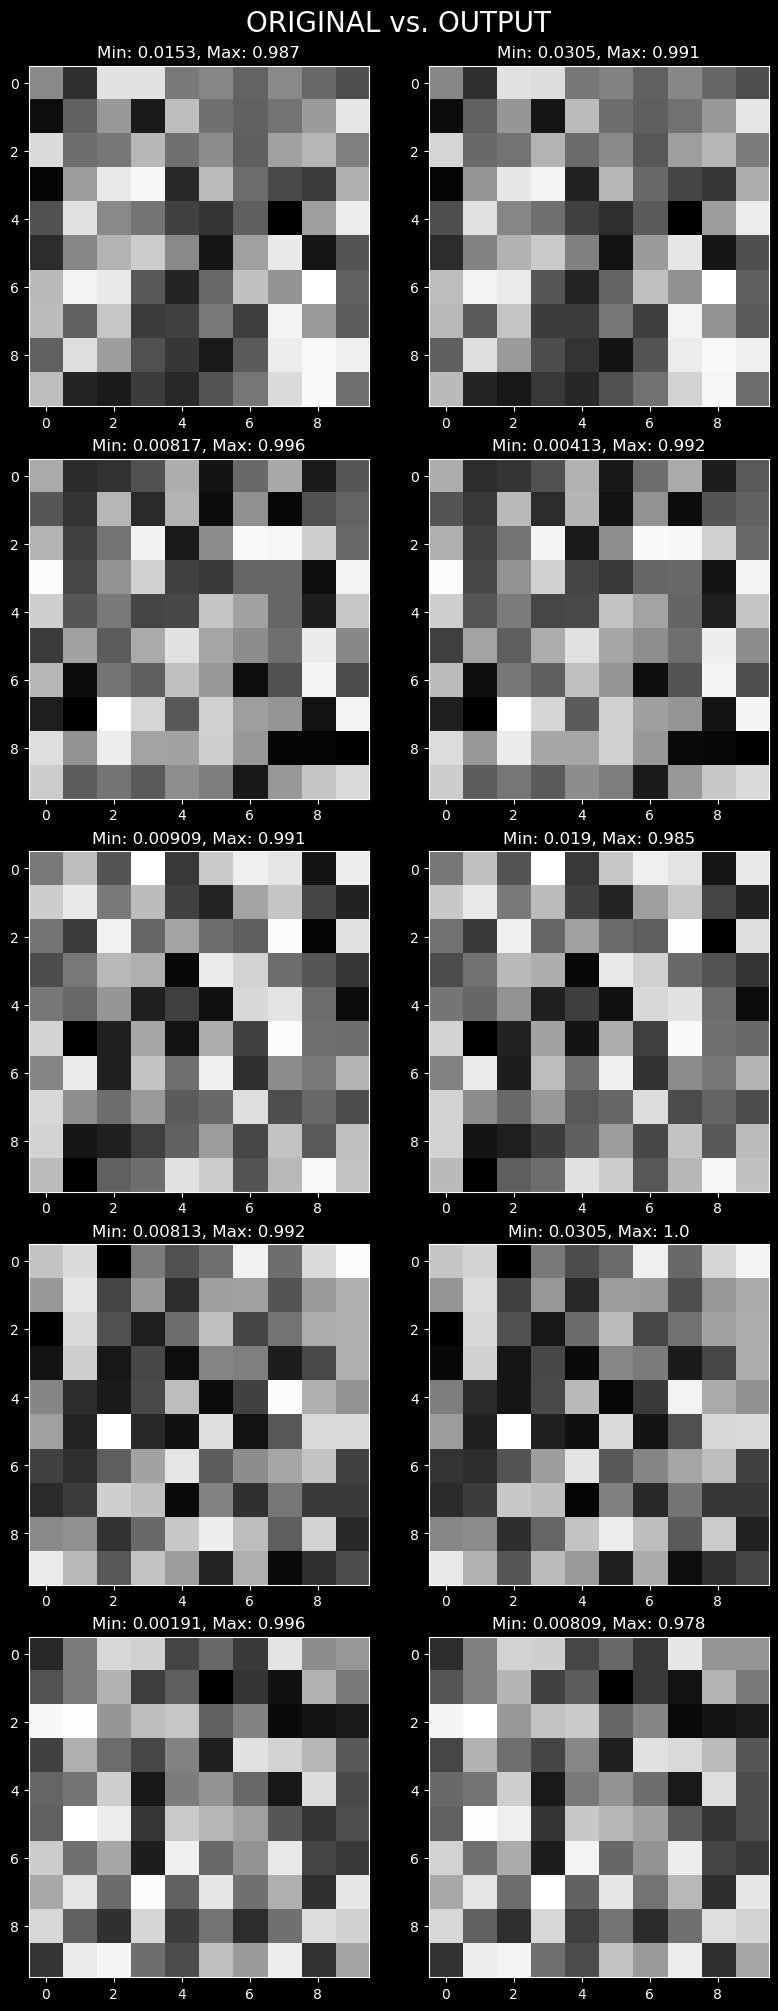

In [8]:
plot_images(np.reshape(y_test[0:5], (5,image_size,image_size)),
           np.reshape(model(x_test[:5]), (5,image_size,image_size)),
           main_title='ORIGINAL vs. OUTPUT')

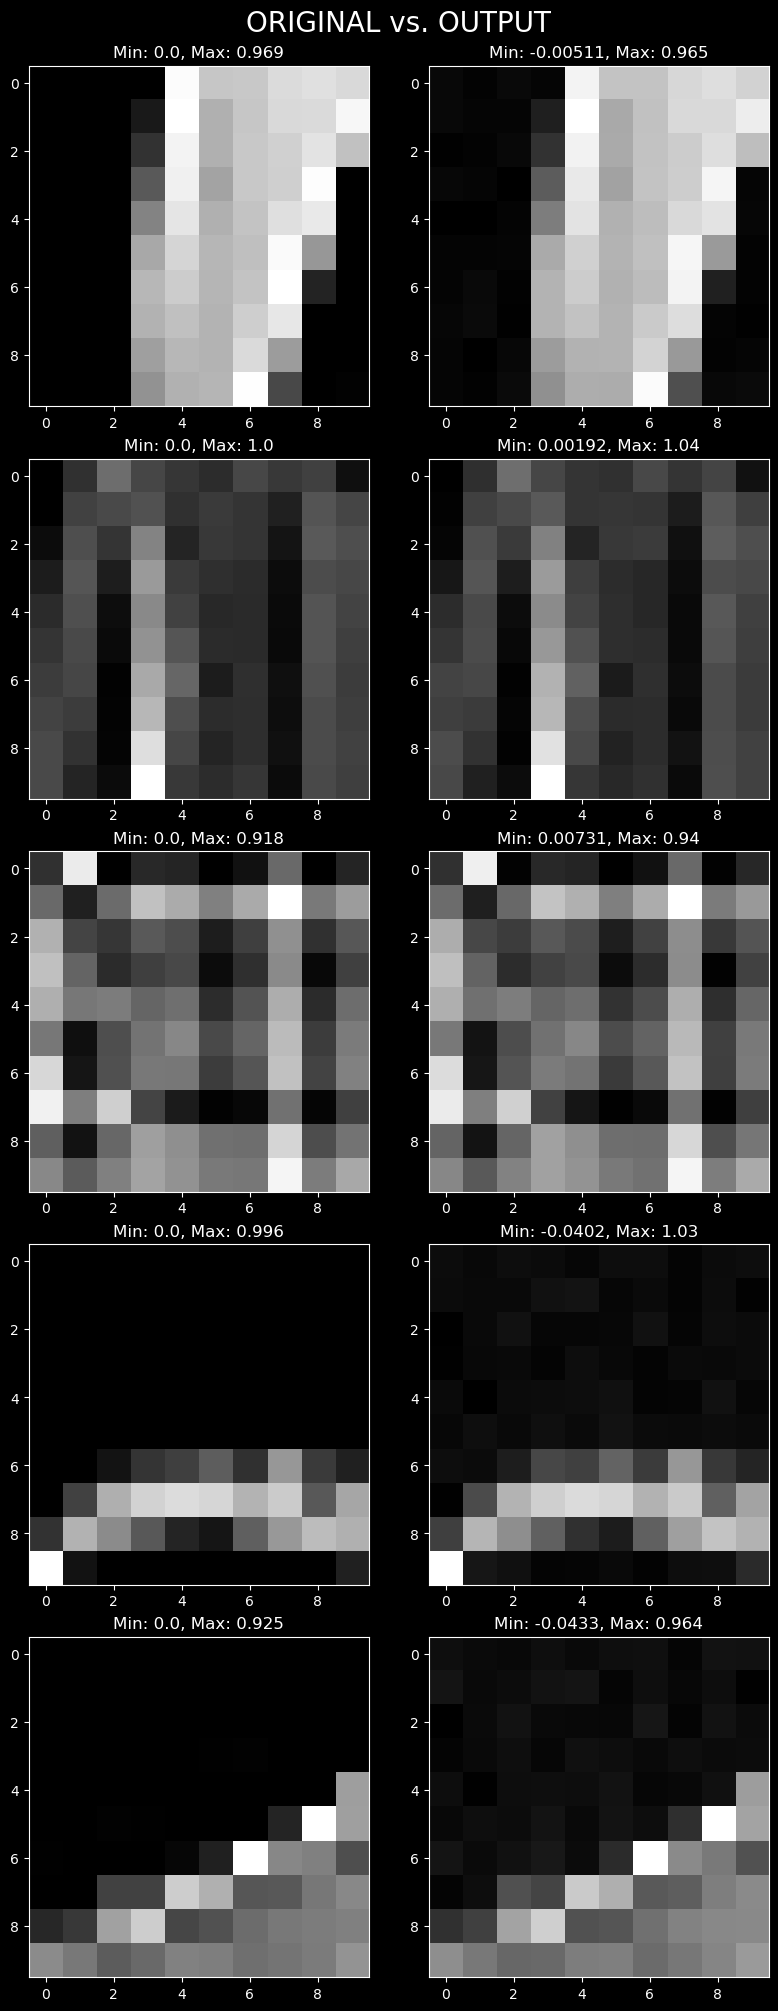

In [22]:
# crop 10x10 bits of the images
y_cropped = np.reshape(np.reshape(y_fash[5:10],(5,28,28))[:,5:15,5:15],
                       (5,100))
x_cropped = y_cropped @ A

plot_images(np.reshape(y_cropped, (5,image_size,image_size)),
           np.reshape(model(x_cropped), (5,image_size,image_size)),
           main_title='ORIGINAL vs. OUTPUT')

## Load data and model

In [9]:
# import encoded data from .npz archive
image_size = 10
with np.load('normally-encoded-random-images-10.npz') as data:
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
    A = data['A']
A_inv = np.linalg.pinv(A)

In [10]:
# import encoded data from .npz archive
with np.load('normally-encoded-fashion-mnist.npz') as data:
    y_fash = data['y_test']

In [11]:
model = tf.keras.models.load_model('random-image-model-10-sigmoid')

## 1. Comparison of J and $A^\#$
### The mean absolute error between J and $A^\#$ is ~30% of the mean absolute size of $A^\#$. This is basically constant over all of the encoded random images.

In [12]:
x = tf.Variable(x_test[0:25])
Js = batchJ(x, model)

In [13]:
J = Js[10].numpy()
print('A# MAE Norm:', mae(A_inv,0),
      'A# RMSE Norm:', rmse(A_inv,0))
print('J MAE Norm:', mae(J,0),
      'J RMSE Norm:', rmse(J,0))
print('MAE:', mae(J, A_inv.T),
    'RMSE:', rmse(J, A_inv.T))
print('MAE/A# MAE Norm:', mae(J, A_inv.T)/mae(A_inv,0))
print('RMSE/A# RMSE Norm:', rmse(J, A_inv.T)/rmse(A_inv,0))

A# MAE Norm: 0.001793299789740582 A# RMSE Norm: 0.0022488621738479433
J MAE Norm: 0.0018439977324035271 J RMSE Norm: 0.0023123550432861462
MAE: 0.000520092822393193 RMSE: 0.0006514593877978858
MAE/A# MAE Norm: 0.29002000968752106
RMSE/A# RMSE Norm: 0.2896839990345865


In [14]:
AinvT_Ainv = A_inv.T @ A_inv
JJT = J @ J.T
print('A#T A# MAE Norm:', mae(AinvT_Ainv,0),
      'A#T A# RMSE Norm:', rmse(AinvT_Ainv,0))
print('JJT MAE Norm:', mae(JJT,0),
      'JJT RMSE Norm:', rmse(JJT,0))
print('MAE:', mae(JJT, AinvT_Ainv),
    'RMSE:', rmse(JJT, AinvT_Ainv))
print('MAE/A#T A# MAE Norm:', mae(JJT, AinvT_Ainv)/mae(AinvT_Ainv,0))
print('RMSE/A#T A# RMSE Norm:', rmse(JJT, AinvT_Ainv)/rmse(AinvT_Ainv,0))

A#T A# MAE Norm: 0.0001240054652781125 A#T A# RMSE Norm: 0.0002826154609287885
JJT MAE Norm: 0.00011236127118580896 JJT RMSE Norm: 0.000288775085086185
MAE: 2.326650931429422e-05 RMSE: 3.1505814665089326e-05
MAE/A#T A# MAE Norm: 0.18762487009837348
RMSE/A#T A# RMSE Norm: 0.11147944476055378


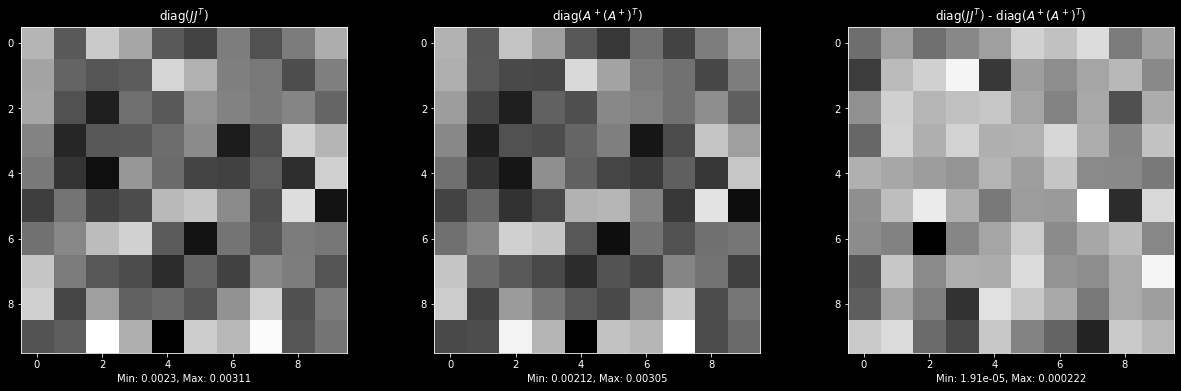

In [15]:
JJt_diag = np.diagonal(JJT)
AinvT_Ainv_diag = np.diagonal(AinvT_Ainv)
diff = JJt_diag - AinvT_Ainv_diag

fig, axs = plt.subplots(1,3,figsize=(21,6))

axs[0].set_title('diag($J J^T$)')
axs[0].imshow(np.reshape(JJt_diag,(10,10)), cmap='gray')
axs[0].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(JJt_diag), np.max(JJt_diag)))

axs[1].set_title('diag($A^+ (A^+)^T$)')
axs[1].imshow(np.reshape(AinvT_Ainv_diag,(10,10)), cmap='gray')
axs[1].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(AinvT_Ainv_diag), np.max(AinvT_Ainv_diag)))

axs[2].set_title('diag($J J^T$) - diag($A^+ (A^+)^T$)')
axs[2].imshow(np.reshape(diff,(10,10)), cmap='gray')
axs[2].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(diff), np.max(diff)))
plt.show()

## 2. Comparison of diag($J J^T$) vs. pixel mean of (noisy - clean)$^2$ reconstructed images
### Procedure: Add multiple realizations of Gaussian noise to a single encoded image, calculate error image (noisy recon - clean recon)^2 for each noisynetwork output, take average.

In [40]:
x_clean = x_test[2:3] # choose one encoded image (size 1x500)
JJt_diag = np.reshape(batch_JJt_diag(tf.Variable(x), model),(10,10)) # 1x100

In [33]:
N = 2500
sigma = np.sqrt(0.1*np.max(x))

# add N realizations of WGN
noise = sigma*np.random.randn(N, 500)
x_noisy = x_clean + noise # broadcasted

# feed through network
y_clean = model(x) # 1 X 100
y_noisy = model(x_noisy) # N x 100
devsq = np.reshape((y_noisy-y_clean)**2, (N, 10, 10))
mean_devsq = np.mean(devsq, axis=0) # 10 x 10

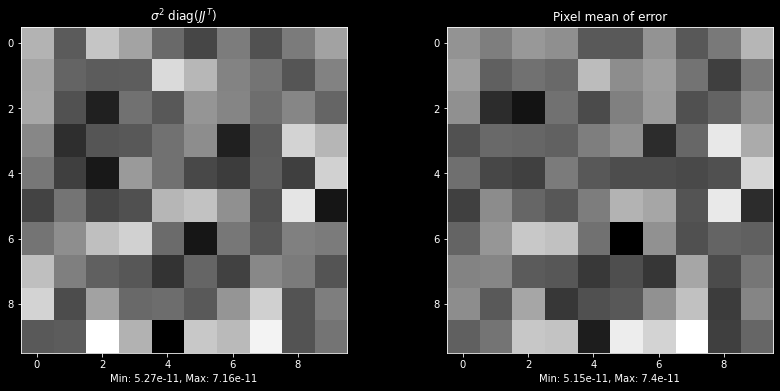

In [41]:
theo_variance = sigma**2 * JJt_diag
fig, axs = plt.subplots(1,2,figsize=(14,6))

axs[0].set_title('$\sigma^2$ diag($J J^T$)')
axs[0].imshow(theo_variance, cmap='gray')
axs[0].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(theo_variance), np.max(theo_variance)))

axs[1].set_title('Pixel mean of error')
axs[1].imshow(mean_devsq, cmap='gray')
axs[1].set_xlabel("Min: {0:.3}, Max: {1:.3}".format(
            np.min(mean_devsq), np.max(mean_devsq)))
plt.show()

### Plot MAE and RMSE between diag(JJ$^T$) and mean$((y_{noisy} - y_{clean})^2)$ over $\sigma$

In [44]:
sigmas = np.max(x_clean) * 10.0**np.arange(-5,2,1)
maes = []
rmses = []

for sigma in sigmas:
    # add N realizations of WGN
    noise = sigma*np.random.randn(N, 500)
    x_noisy = x_clean + noise # broadcasted

    # feed through network
    y_clean = model(x) # 1 X 100
    y_noisy = model(x_noisy) # N x 100
    devsq = np.reshape((y_noisy-y_clean)**2, (N, 10, 10))
    mean_devsq = np.mean(devsq, axis=0) # 10 x 10
    
    # calculate MAE and RMSE
    maes.append(mae(JJt_diag, mean_devsq))
    rmses.append(rmse(JJt_diag, mean_devsq))

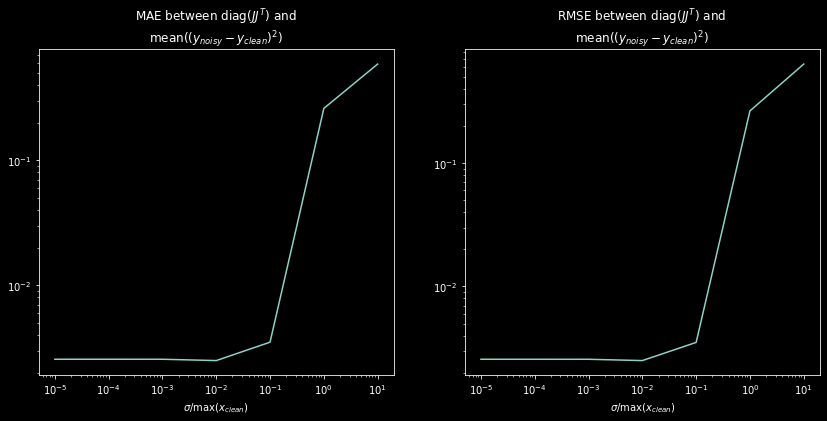

In [48]:
fig, axs = plt.subplots(1,2,figsize=(14,6))
X = 10.0**np.arange(-5,2,1)

axs[0].set_title('MAE between diag($JJ^T$) and \nmean$((y_{noisy} - y_{clean})^2)$')
axs[0].set_xlabel('$\sigma$/max($x_{clean}$)')
axs[0].plot(X, maes)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].set_title('RMSE between diag($JJ^T$) and \nmean$((y_{noisy} - y_{clean})^2)$')
axs[1].set_xlabel('$\sigma$/max($x_{clean}$)')
axs[1].plot(X, rmses)
axs[1].set_xscale('log')
axs[1].set_yscale('log')